# Open Street Map Data

This notebook is used to extract hiking route data from the Overpass API ([Link](https://overpass-turbo.eu/)).

First, we request hiking routes from the API using Overpass QL (short for "Overpass Query Language").
In OpenStreetMap, hiking routes are defined as relations. We search for relations with specific signage and the tags "hiking routes," "local walking network",
within an area slightly larger than Switzerland. Using "Center" as Output, OpenStreetMap calculates the central location of each route.
Since the "name" tag is often missing, we interpolate the name by concatenating the start and end points of each hiking route.
Finally, we retrieve the ID, name, latitude, and longitude as data points. 

The data is then converted into a DataFrame object, and a table is created in an SQL database (hosted on Microsoft Azure).

In [ ]:
# Import required libraries
import os
import json
import overpy
import pyodbc
import urllib
import pymssql
import pandas as pd 
from sqlalchemy import Integer, String, Float, DATETIME, create_engine

### Connect to API

In [ ]:
# Initialize the Overpass API with a custom URL
api = overpy.Overpass(url="http://overpass.osm.ch/api/interpreter")

# Overpass query for hiking trails within Switzerland. Using 'center', we obtain the coordinates in the middle of a hiking trail
query = """
[out:json];
relation
["route"="hiking"]
//["name"!~"fixme", i]
["network"="lwn"]
["osmc:symbol"~"yellow::yellow_diamond|red:white:red_bar|yellow:white:yellow_diamond|blue:white:blue_bar"]
(45.8899, 6.0872, 47.8085, 10.4921);
out center tags;
"""

# Execute the request
result = api.query(query)

### Save Data to DataFrame

In [ ]:
# Add time and datestamp of API call to dataframe
timestamp_apicall = pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")

# List to store the extracted information
list = []

# Iterate over all relations
for relation in result.relations:

    # Extract relevant data
    name = relation.tags.get('name')
    von = relation.tags.get('from')
    bis = relation.tags.get('to')
    symbol = relation.tags.get('osmc:symbol')
    lat = getattr(relation, 'center_lat')
    lon = getattr(relation, 'center_lon')
    
    dict = {    
    'id': relation.id,
    'name': name,
    'symbol': symbol,
    'von': von,
    'bis': bis,
    'lat': lat,
    'lon': lon,
    'timestamp_apicall': timestamp_apicall}

    # Each tuple is now saved in the list as a new row
    list.append(dict)

# Once all data is processed, create the DataFrame
df_wanderwege = pd.DataFrame(list)

# Print the DataFrame
print(df_wanderwege.head())

### Identifying missing data

In [ ]:

print("\nMissing Data:")
print(df_wanderwege.isnull())



### Input Missing Data

In [ ]:
for index, row in df_wanderwege.iterrows():
    if pd.isnull(row["name"]) and not pd.isnull(row["von"]) and not pd.isnull(row["bis"]):
        df_wanderwege.at[index, "name"] = f"{row['von']} - {row['bis']}"

# Resultierender DataFrame anzeigen
print(df_wanderwege)


### Identifying duplicate rows


In [ ]:
print("\nDuplicate rows:")
print(df_wanderwege.duplicated())

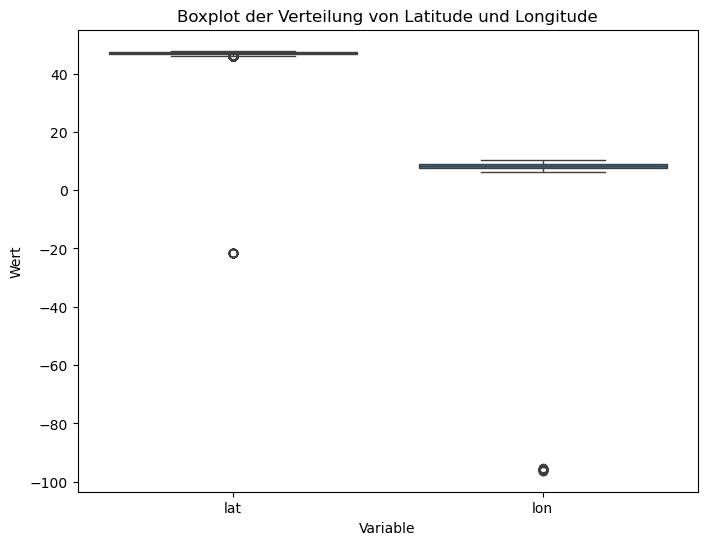

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame für die relevanten Spalten vorbereiten
df_melted = df_wanderwege[["lat", "lon"]].melt(var_name="Variable", value_name="Wert")

# Boxplot zeichnen
plt.figure(figsize=(8, 6))
sns.boxplot(x="Variable", y="Wert", data=df_melted)
plt.title("Boxplot der Verteilung von Latitude und Longitude")
plt.ylabel("Wert")
plt.xlabel("Variable")
plt.show()


### optional: Store data in csv


In [ ]:
df_wanderwege.to_csv("../data/processed/overpass.csv")

In [ ]:
# Convert lat and lon to numeric, timestamp to datetime
df_wanderwege['lat'] = pd.to_numeric(df_wanderwege['lat'], errors='coerce')
df_wanderwege['lon'] = pd.to_numeric(df_wanderwege['lon'], errors='coerce')
df_wanderwege['timestamp_apicall'] = pd.to_datetime(df_wanderwege['timestamp_apicall'], errors='coerce')

### Connect to SQL Server

In [ ]:
# Load configuration from config/db_config.json
with open('../config/db_config.json', 'r') as f:
    db_config = json.load(f)

# Get database credentials
server = db_config['server']
database = db_config['database']
db_user = db_config['db_user']
db_password = db_config['db_password']

### Create empty SQL table

In [ ]:
# Create table if it doesn't exist
table_name = "OVRP_HikingRoutes"
query = f"""
    IF OBJECT_ID(N'dbo.{table_name}', N'U') IS NULL
    BEGIN
        CREATE TABLE {table_name} (
            id                      INT         NOT NULL,
            name                    VARCHAR(255) NULL,
            von                     VARCHAR(255) NULL,
            bis                     VARCHAR(255) NULL,
            lat                     FLOAT       NOT NULL,
            lon                     FLOAT       NOT NULL,
            symbol                  VARCHAR(255) NULL,
            timestamp_apicall       DATETIME    NULL,
            PRIMARY KEY (id)
        );
    END
    """

conn = pymssql.connect(server, db_user, db_password, database)
cursor = conn.cursor()
cursor.execute(query)

conn.commit()
conn.close()

In [ ]:
# Create connection string for SQLAlchemy
connection_string = f"mssql+pymssql://{db_user}:{db_password}@{server}/{database}"
engine = create_engine(connection_string)

In [ ]:
# Ingest data to tabledatabase table
df_wanderwege.to_sql(table_name, con=engine, if_exists='replace', index=False)
print("DataFrame erfolgreich in die MSSQL-Datenbank geladen!")